# Rigorous estimates of p-laplacian's first eigenvalue

In [1]:
using DifferentialEquations
using Plots; gr()
using IntervalArithmetic
using LinearAlgebra
using LaTeXStrings

**functions**

- `plaplace_solve` - Numeric solution of p-laplace
- `cubic_natural_spline` - IA interpolation of given points with natural cubic spline
- `cubic_end_slope_spline` - IA interpolation of given points with end slope cubic spline
- `get_u1` - Rebuilds interval expression of U₁ˢ by integrating U₂ˢ.
- `der_cubic_spline`
- `lower_estimate`
- `upper_estimate`

In [2]:
"""
Numeric solution of p-laplace

Inputs:
λi  ... initial interval of λ₁
p   ... p of p-laplacian
n   ... number of solution points
u₂0 ... initial condition for u₂
dom ... domain

Outputs:
t, tᴵ    ... solution points (Float64, Interval)
U₁, U₁ᴵ  ... numerical u₁ solution at t, tᴵ (Float64, Interval)
U₂, U₂ᴵ  ... numerical u₂ solution at t, tᴵ (Float64, Interval)
Λ₁       ... numerical first eigenvalue λ₁
"""
function plaplace_solve(λi, p, n; u₂0=1.0, dom=(0.0, 1.0))
   
    function sl(du,u,P,t)
        λ, p = P
        du[1] = abs(u[2])^(1/(p-1)) * sign(u[2])
        du[2] = -λ * abs(u[1])^(p-1)*sign(u[1]) 
    end
    
    tl, tr = dom
    
    u0 = [0.0; u₂0;] # initial condition
    a, b = λi
    Λ₁ = (a + b)/2
    Δt = (tr-tl)/(n-1)
    e = 1e-12 # stop condition

    while (b-a) >= e
        prob = ODEProblem(sl, u0, dom, (Λ₁, p))
        sol = solve(prob, saveat=Δt, abstol=1e-8,reltol=1e-8)
        if sol(tr)[1] == 0
            break
        else
            probA = ODEProblem(sl, u0, dom, (a, p))
            solA = solve(probA, saveat=Δt, abstol=1e-8,reltol=1e-8)
            probS = ODEProblem(sl, u0, dom, (Λ₁, p))
            solS = solve(probS, saveat=Δt, abstol=1e-8,reltol=1e-8)
            if solA(tr)[1] * solS(tr)[1] < 0
                b = Λ₁
            else
                a = Λ₁
            end
            Λ₁ = (a+b)/2
        end
    end

    prob = ODEProblem(sl, u0, dom, (Λ₁, p))
    sol = solve(prob, saveat=Δt, abstol=1e-8,reltol=1e-8)
    
    t = LinRange(0,1,n-1)
    tᴵ = [@interval(i) for i in t]
    U₁ = [u[1] for u in sol(t).u]
    U₁ᴵ = [@interval(u[1]) for u in sol(t).u]
    U₂ = [u[2] for u in sol(t).u]
    U₂ᴵ = [@interval(u[2]) for u in sol(t).u]

    
    return t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁, sol
end;

In [3]:
"""
IA interpolation of given points with natural cubic spline

Inputs:
t, tᴵ        ... mesh points (Float64, Interval)
U, Uᴵ        ... values to be interpolated (Float64, Interval)
Uₗd2, Uᵣd2    ... left and right boundary values of first derivative
ns=10        ... number of mesh points for single piece of spline

Outputs:
csc_u ... natural cubic spline coefficients 
Uˢ    ... interval values of natural cubic spline in mesh points
"""
function cubic_natural_spline(t, tᴵ, U, Uᴵ, Uₗd2, Uᵣd2; ns=10)
    # A matrix
    n=length(Uᴵ)
    dv = [4..4 for i in 1:n-2]
    ev = [1..1 for i in 1:n-3]
    A = Array(SymTridiagonal(dv,ev))
    A⁻¹ = inv(A)

    # right-hand side
    h = 1.0/(n-1)
    rhs = []
    for i in 3:length(Uᴵ)
        append!(rhs, 6/h^2 * (Uᴵ[i] - 2 * Uᴵ[i-1] + Uᴵ[i-2]))
    end
    
    rhs[1] = rhs[1]-Uₗd2
    rhs[end] = rhs[end]-Uᵣd2    

    # second derivative vector 
    Ud2 = []
    append!(Ud2, @interval(Uₗd2))
    append!(Ud2, A⁻¹*rhs)
    append!(Ud2, @interval(Uᵣd2))

    # spline coefficients
    csc_U = []
    for i in 1:length(Uᴵ)-1
        a=b=c=d=0
        a = (Ud2[i+1]-Ud2[i])/(6*h)
        b = Ud2[i]/2 
        c = (Uᴵ[i+1] - Uᴵ[i])/h - h*(2*Ud2[i]+Ud2[i+1])/6
        d = Uᴵ[i]
        append!(csc_U, [[a,b,c,d]])
    end 
    
    Uˢ = Interval[] 
    for i in 1:length(Uᴵ)-1
        x_dom = t[i]..t[i+1]
        x_int = mince(x_dom,ns)
        f(x) = csc_U[i][4] + (x-t[i])*(csc_U[i][3] + (x-t[i])*(csc_U[i][2] + csc_U[i][1]*(x-t[i])))
        append!(Uˢ, f.(x_int))
    end
        
    return csc_U, Uˢ
end;

In [4]:
"""
IA interpolation of given points with end slope cubic spline

Inputs:
t, tᴵ        ... mesh points (Float64, Interval)
U, Uᴵ        ... values to be interpolated (Float64, Interval)
Uₗd2, Uᵣd2    ... left and right boundary values of first derivative
ns=10        ... number of mesh points for single piece of spline

Outputs:
csc_u ... natural cubic spline coefficients 
Uˢ    ... interval values of natural cubic spline in mesh points
"""


function cubic_end_slope_spline(t, tᴵ, U, Uᴵ, Uₗd1, Uᵣd1; ns=10)
    # A matrix
    n=length(Uᴵ)
    dv = [4..4 for i in 1:n-2]
    ev = [1..1 for i in 1:n-3]
    A = Array(SymTridiagonal(dv,ev))
    A[1,1] = 3.5..3.5
    A[end,end] = 3.5..3.5
    A⁻¹ = inv(A)

    # right-hand side
    h = 1.0/(n-1)
    rhs = []
    for i in 3:length(Uᴵ)
        append!(rhs, 6/h^2 * (Uᴵ[i] - 2 * Uᴵ[i-1] + Uᴵ[i-2]))
    end
    
    rhs[1] = rhs[1] - 3/h * ( (Uᴵ[2]-Uᴵ[1])/h - Uₗd1)
    rhs[end] = rhs[end] - 3/h * (Uᵣd1 - (Uᴵ[end]-Uᴵ[end-1])/h)    

    # second derivative vector 
    sol = A⁻¹*rhs
    Ud2 = []
    
    σ₀ = 3/h * ( (Uᴵ[2]-Uᴵ[1])/h - Uₗd1) - sol[1]/2
    σ₁ = 3/h * (Uᵣd1 - (Uᴵ[end]-Uᴵ[end-1])/h)   - sol[end]/2
    append!(Ud2, @interval(σ₀))
    append!(Ud2, sol)
    append!(Ud2, @interval(σ₁))

    # spline coefficients
    csc_U = []
    for i in 1:length(Uᴵ)-1
        a=b=c=d=0
        a = (Ud2[i+1]-Ud2[i])/(6*h)
        b = Ud2[i]/2 
        c = (Uᴵ[i+1] - Uᴵ[i])/h - h*(2*Ud2[i]+Ud2[i+1])/6
        d = Uᴵ[i]
        append!(csc_U, [[a,b,c,d]])
    end 
    
    Uˢ = Interval[]
    for i in 1:length(Uᴵ)-1
        x_dom = t[i]..t[i+1]
        x_int = mince(x_dom,ns)
        f(x) = csc_U[i][4] + (x-t[i])*(csc_U[i][3] + (x-t[i])*(csc_U[i][2] + csc_U[i][1]*(x-t[i])))
        append!(Uˢ, f.(x_int))
    end
        
    return csc_U, Uˢ
end;

**poznámky - get_u1**
- po nasčítání intervalového integrálu je třeba funkci "zespojitit" - cyklus se sjednocením dvou po sobě jdoucích intervalů
- s integrálem začínáme na 0 (u1 je posazené na osu)
- na konci odečítáme nejmenší dolní hodnotu U₁ˢ - ta je ovšem záporná, posun je tedy směrem nahoru a u1 >= 0

In [5]:
"""
Rebuilds interval expression of U₁ˢ by integrating U₂ˢ.

Inputs:
p             ... p of p-laplacian
U₂ˢ           ... intervals of u₂ spline
t             ... mesh points of numeric solution
U₁            ... u₁(t) numeric values  

Output:
U₁ˢ  ... interval values of u₁(t)
"""
function get_u1(p, U₂ˢ, t, U₁)
    
    f(x) = abs(x)^(1/(p-1))*sign(x)
    ni = mince(0..1,length(U₂ˢ))

    U₁_tmp = Interval[0..0]#[U₁[1]..U₁[1]]
    for i in 1:length(U₂ˢ)
        append!(U₁_tmp, U₁_tmp[end] + f(U₂ˢ[i]) * diam(ni[i]))
    end
    
    U₁ˢ = Interval[]
    for i in 1:length(U₁_tmp)-1
        append!(U₁ˢ, U₁_tmp[i] ∪ U₁_tmp[i+1])
    end
    
    U₁ˢ = U₁ˢ .- inf(minimum(U₁ˢ))
    
    return U₁ˢ
end;

In [6]:
"""
Z koeficientů intervalově vypočítá derivaci kubického splinu

Vstupní parametry:
csc           ... koeficienty splinu
t, tᴵ         ... bodové i intervalově dělení časové osy
ns            ... počet bodů dělení jednotlivého oblouku splinu
plt_res=true  ... vykreslení řešení


Výstupní hodnoty:
Uˢ   ... intervalové hodnoty derivace splinu

"""
function der_cubic_spline(csc, t, tᴵ, ns)
    
    Uₜₘₚ = Interval[]
    csc_Uder = [ [@interval(3) * c[1], @interval(2) * c[2], c[3]] for c in csc ] 
    for i in 1:length(t)-1
        x_dom = t[i]..t[i+1] 
        x_int = mince(x_dom,ns)
        f(x) = csc_Uder[i][3] + (x-t[i])*(csc_Uder[i][2] + (x-t[i])*csc_Uder[i][1])
        append!(Uₜₘₚ, f.(x_int))
    end
    
    Uˢ = Interval[]
    for i in 1:length(Uₜₘₚ)-1
        append!(Uˢ, Uₜₘₚ[i] ∪ Uₜₘₚ[i+1])
    end
    append!(Uˢ,Uₜₘₚ[end])
        
    return Uˢ
end;

In [7]:
"""
Intervalově vypočítá dolní odhad λ₁

Vstupní parametry:
numerator     ... čitatel 
denominator   ... jmenovatel
plt_res=true  ... vykreslení řešení


Výstupní hodnoty:
λ₁ˡᵒʷ    ... dolní odhad λ₁
Fˡᵒʷ     ... intervalové hodnoty funkce dolního odhadu
"""
function lower_estimate(U₂ˢ_der, U₁ˢ, p)
    f(x,y) = -x / y^(p-1)
    λ₁ᵗᵐᵖ = f.(U₂ˢ_der, U₁ˢ)

    Fˡᵒʷ = Interval[]
    for i in 1:length(λ₁ᵗᵐᵖ)-1
        append!(Fˡᵒʷ, λ₁ᵗᵐᵖ[i] ∪ λ₁ᵗᵐᵖ[i+1])
    end
    append!(Fˡᵒʷ,λ₁ᵗᵐᵖ[end])
    
    λ₁ˡᵒʷ = inf(minimum(Fˡᵒʷ))
    
    return λ₁ˡᵒʷ, Fˡᵒʷ
end;

In [8]:
"""
Intervalově vypočítá horní odhad λ₁

Vstupní parametry:
p             ... hodnota p z p-laplaciánu
U₁ˢ           ... intervalové hodnoty U₁
U₁ˢ_der       ... intervalové hodnoty U₁' 
plt_res=true  ... vypíše řešení


Výstupní hodnoty:
λ₁ᵘᵖ    ... horní odhad λ₁
"""
function upper_estimate(p, U₁ˢ, U₁ˢ_der)
    
    f(x) = abs(x)^(p)
    ni = mince(0..1,length(U₁ˢ))

    numerator = 0..0
    for i in 1:length(U₁ˢ_der)
        numerator = numerator + f(U₁ˢ_der[i]) * diam(ni[i])
    end
    
    denominator = 0..0
    for i in 1:length(U₁ˢ)
        denominator = denominator + f(U₁ˢ[i]) * diam(ni[i])
    end

    λ₁ᵘᵖ = sup(numerator/denominator)

    return λ₁ᵘᵖ 
end;

## Numeric experiments 


**Experiment 1**
- $p \in [1.2, 2.9]$ 
- $n = 21$
- $ns = 11$

In [9]:
λ₁ᵉˣᵃᶜᵗ(P) = (P-1)*(2*(π/P)/(sin(π/P)))^P

λ₁ˡᵒʷs = Float64[]
λ₁ˡᵒʷs_err = Float64[]

λ₁ᵘᵖs = Float64[]
λ₁ᵘᵖs_err = Float64[]

n = 21 # number of mesh points
ns = 11 # number of mesh points of one spline piece
si = mince(0..1,(n-1)*ns) # intervaly dělení splinu

ps = 1.2:0.1:2.9
for p in ps
    λ₁ = λ₁ᵉˣᵃᶜᵗ(p)
    λᵢₙᵢₜ = (3.,1.5*λ₁)
    r = 10/(n*ns)
    dom = (-r, r+1)

    ### lower estimate
    t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁, _ = plaplace_solve(λᵢₙᵢₜ, p, n, dom=dom); #, 
    ud1 = -Λ₁ * U₁[end]^(p-1)
    csc_U₂ˢ, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, ud1, ud1, ns=ns);
    U₁ˢ = get_u1(p,U₂ˢ, t, U₁);
    U₂ˢ_der = der_cubic_spline(csc_U₂ˢ, t, tᴵ, ns);
    λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p)
    append!(λ₁ˡᵒʷs, λ₁ˡᵒʷ)
    append!(λ₁ˡᵒʷs_err, λ₁ˡᵒʷ-λ₁)

    ### upper estimate
    t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁, _ = plaplace_solve(λᵢₙᵢₜ, p, n);
    csc_U₁, U₁ˢ = cubic_natural_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns);
    U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns); 
    λ₁ᵘᵖ = upper_estimate(p, U₁ˢ, U₁ˢ_der);
    append!(λ₁ᵘᵖs, λ₁ᵘᵖ)
    append!(λ₁ᵘᵖs_err, λ₁ᵘᵖ-λ₁)

end

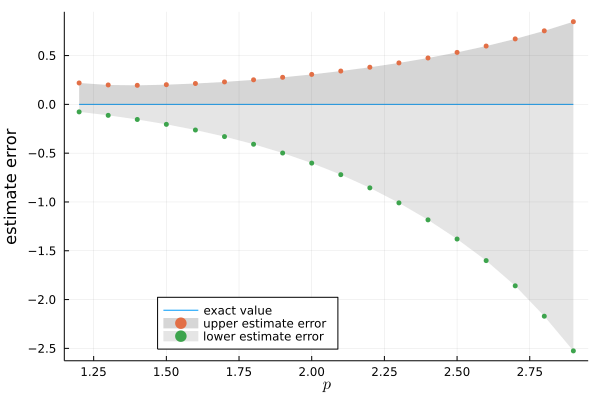

In [10]:
plot(ps, zeros(length(ps)), label="exact value")
plot!(ps,λ₁ᵘᵖs_err, line = :scatter, msw = 0, ms = 3, label="upper estimate error", 
    fillrange = zeros(length(ps)), fillalpha = 0.2, fillcolor=:gray20)
plot!(ps, λ₁ˡᵒʷs_err, line = :scatter, msw = 0, ms = 3, label="lower estimate error", 
    fillrange = zeros(length(ps)), fillalpha = 0.2, fillcolor=:gray50, 
        c = 3, legend=:bottom, xlabel=L"p", ylabel="estimate error")

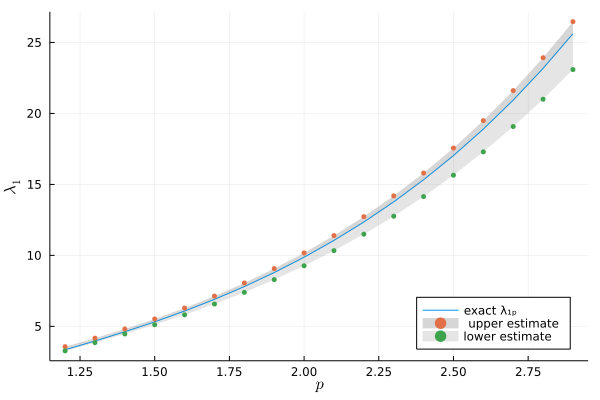

In [11]:
plot(ps, λ₁ᵉˣᵃᶜᵗ.(ps), label="exact λ₁ₚ")
plot!(ps,λ₁ᵘᵖs, line = :scatter, msw = 0, ms = 3, label=" upper estimate",
    fillrange = λ₁ᵉˣᵃᶜᵗ.(ps), fillalpha = 0.2, fillcolor=:gray20)
plot!(ps, λ₁ˡᵒʷs, line = :scatter, msw = 0, ms = 3, label="lower estimate", 
    fillrange = λ₁ᵉˣᵃᶜᵗ.(ps), fillalpha = 0.2, fillcolor=:gray50,
        c = 3, legend=:bottomright, xlabel=L"p", ylabel=L"\lambda_1")

**Experiment 2**

- $p \in [1.2, 2.9]$ 
- $n = 201$
- $ns = 101$

In [12]:
λ₁ᵉˣᵃᶜᵗ(P) = (P-1)*(2*(π/P)/(sin(π/P)))^P

λ₁ˡᵒʷs = Float64[]
λ₁ˡᵒʷs_err = Float64[]

λ₁ᵘᵖs = Float64[]
λ₁ᵘᵖs_err = Float64[]

n = 201 # number of mesh points
ns = 101 # number of mesh points of one spline piece
si = mince(0..1,(n-1)*ns) # intervaly dělení splinu

ps = 1.2:0.1:2.9
for p in ps
    λ₁ = λ₁ᵉˣᵃᶜᵗ(p)
    λᵢₙᵢₜ = (3.,1.5*λ₁)
    r = 10/(n*ns)
    dom = (-r, r+1)

    ### lower estimate
    t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁, _ = plaplace_solve(λᵢₙᵢₜ, p, n, dom=dom); #, 
    ud1 = -Λ₁ * U₁[end]^(p-1)
    csc_U₂ˢ, U₂ˢ = cubic_end_slope_spline(t, tᴵ, U₂, U₂ᴵ, ud1, ud1, ns=ns);
    U₁ˢ = get_u1(p,U₂ˢ, t, U₁);
    U₂ˢ_der = der_cubic_spline(csc_U₂ˢ, t, tᴵ, ns);
    λ₁ˡᵒʷ, Fˡᵒʷ = lower_estimate(U₂ˢ_der, U₁ˢ, p)
    append!(λ₁ˡᵒʷs, λ₁ˡᵒʷ)
    append!(λ₁ˡᵒʷs_err, λ₁ˡᵒʷ-λ₁)

    ### upper estimate
    t, tᴵ, U₁, U₁ᴵ, U₂, U₂ᴵ, Λ₁, _ = plaplace_solve(λᵢₙᵢₜ, p, n);
    csc_U₁, U₁ˢ = cubic_natural_spline(t, tᴵ, U₁, U₁ᴵ, -1, -1, ns=ns);
    U₁ˢ_der = der_cubic_spline(csc_U₁, t, tᴵ, ns); 
    λ₁ᵘᵖ = upper_estimate(p, U₁ˢ, U₁ˢ_der);
    append!(λ₁ᵘᵖs, λ₁ᵘᵖ)
    append!(λ₁ᵘᵖs_err, λ₁ᵘᵖ-λ₁)

end

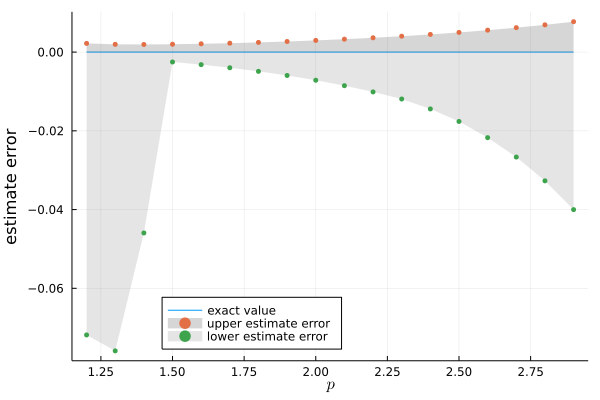

In [13]:
plot(ps, zeros(length(ps)), label="exact value")
plot!(ps,λ₁ᵘᵖs_err, line = :scatter, msw = 0, ms = 3, label="upper estimate error", 
    fillrange = zeros(length(ps)), fillalpha = 0.2, fillcolor=:gray20)
plot!(ps, λ₁ˡᵒʷs_err, line = :scatter, msw = 0, ms = 3, label="lower estimate error", 
    fillrange = zeros(length(ps)), fillalpha = 0.2, fillcolor=:gray50, 
        c = 3, legend=:bottom, xlabel=L"p", ylabel="estimate error")

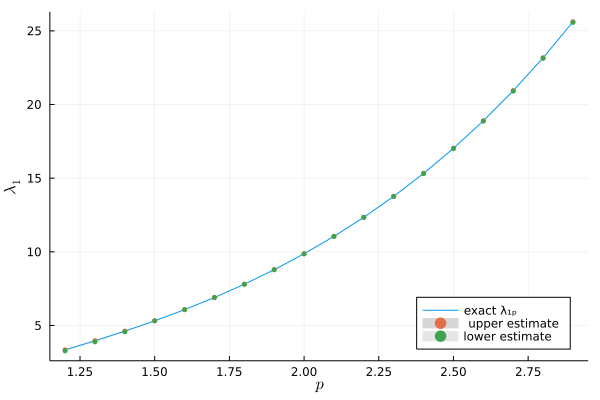

In [14]:
plot(ps, λ₁ᵉˣᵃᶜᵗ.(ps), label="exact λ₁ₚ")
plot!(ps,λ₁ᵘᵖs, line = :scatter, msw = 0, ms = 3, label=" upper estimate",
    fillrange = λ₁ᵉˣᵃᶜᵗ.(ps), fillalpha = 0.2, fillcolor=:gray20)
plot!(ps, λ₁ˡᵒʷs, line = :scatter, msw = 0, ms = 3, label="lower estimate", 
    fillrange = λ₁ᵉˣᵃᶜᵗ.(ps), fillalpha = 0.2, fillcolor=:gray50,
        c = 3, legend=:bottomright, xlabel=L"p", ylabel=L"\lambda_1")